<h1><center>Brain Tumor Classification</center></h1>

This notebook demonstrates the application of AI in medical imaging.
We will train a simple convolutional neural network (CNN) model followed by a state-of-the-art-model to detect if the MRI images have tumor.

Use [NbViewer](https://nbviewer.jupyter.org/) to view the rendered notebook.

## Contents

1. [Dataset Overview](#1.-Dataset-Overview)
2. [Load and Visualize the Data](#2.-Load-and-Visualize-the-Data)
3. [Train Test Data Split](#3.-Train-Test-Data-Split)
4. [Data Augmentation](#4.-Data-Augmentation)
5. [CNN from Scratch](#5.-CNN-from-Scratch)
6. [Transfer Learning](#6.-Transfer-Learning)
7. [Conclusion](#7.-Conclusion)
8. [Future Work](#8.-Future-Work)
9. [References](#9.-References)

### 1. Dataset Overview

This is a public dataset available on Kaggle, *Brain MRI Images for Brain Tumor Detection* which consists of 253 MRI Images of brain distributed in two classes:

`yes`: has tumor (155 images)

`no` : no tumor (98 images)

[Link to the dataset](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection?)

### 2. Load and Visualize the Data

In [1]:
#Importing the essentials
import os
from pathlib import Path
import glob
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#from tensorflow.keras.utils import np_utils

Using TensorFlow backend.


In [2]:
PATH = 'data/'

#Path to the dataset
DATA_PATH = os.path.join(PATH, "brain_tumor")

In [3]:
DATA_PATH

'data/brain_tumor'

In [4]:
yes_class = os.listdir(DATA_PATH + '/' + 'yes')
no_class = os.listdir(DATA_PATH + '/' + 'no')

In [5]:
#Length of each class
print("Total images present in yes_class: ", len(yes_class))
print("Total images present in no_class: ", len(no_class))

Total images present in yes_class:  155
Total images present in no_class:  98


In [6]:
#List the contents of each class
print("List of first 5 images in yes_class", yes_class[0:5])
print("List of first 5 images in no_class", no_class[0:5])

List of first 5 images in yes_class ['Y10.jpg', 'Y29.jpg', 'Y53.jpg', 'Y163.JPG', 'Y153.jpg']
List of first 5 images in no_class ['no 923.jpg', '10 no.jpg', 'N5.jpg', 'no.jpg', '21 no.jpg']


**Observations**

- There are a total of 253 images out of which 155 of them are labelled `yes` (meaning there is a presence of tumor) and 98 of them are labelled `no` (i.e. there is no tumor).
- Clearly, there is a case of data imbalance since the number of observations aren't equally distributed. But, since we are dealing with deep learning models, with *data augmentation* technique, the model should be able to learn to classify the images with a higher accuracy.

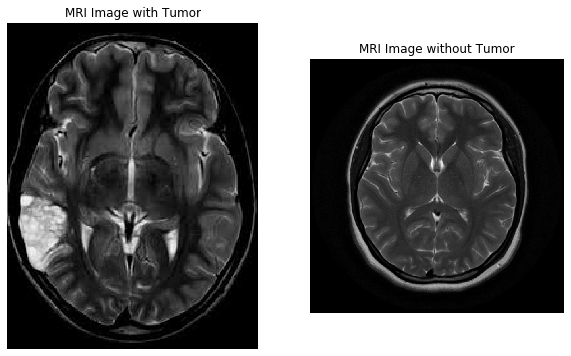

In [7]:
#Display sample images
sample_yes = random.choice(yes_class)
sample_yes_img = load_img(DATA_PATH + '/' + 'yes/' + sample_yes)

sample_no = random.choice(no_class)
sample_no_img = load_img(DATA_PATH + '/' + 'no/' + sample_no)

#Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3)

axes.flatten()[0].imshow(sample_yes_img)
axes.flatten()[0].set_axis_off()
axes.flatten()[0].set_title("MRI Image with Tumor")

axes.flatten()[1].imshow(sample_no_img)
axes.flatten()[1].set_axis_off()
axes.flatten()[1].set_title("MRI Image without Tumor");

There is a clear distinction between the images with and without tumor as seen above.

In [8]:
#Converting images to numpy arrays
sample_yes_array = np.array(sample_yes_img)
sample_no_array = np.array(sample_no_img)

#Finding the maximum pixel values
print("Maximum pixel value of sample image with tumor", sample_yes_array.max())
print("Maximum pixel value of sample image without tumor", sample_no_array.max())

#Print shape of the images
print("Shape of sample image with tumor", sample_yes_array.shape)
print("Shape of sample image without tumor", sample_no_array.shape)

Maximum pixel value of sample image with tumor 248
Maximum pixel value of sample image without tumor 248
Shape of sample image with tumor (256, 197, 3)
Shape of sample image without tumor (630, 630, 3)


**Observations**

- The image shape varies across the dataset and isn't uniform
- The pixel values in a given image varies from 0-255

Though, we can include a pre-processing step at this stage, however, `Keras` API has an in-built class which can achieve the same. We will discuss that later.

### 3. Train Test Data Split

Since our dataset didn't include separate examples for train and test, we will have to split it in this section. We will also include a validation split as well.

Ratio of Train:Val:Test - 70:15:15 (in terms of %)

Before we split the dataset, let us shuffle it.

In [9]:
#Shuffle the images in both the classes

np.random.shuffle(yes_class)
np.random.shuffle(no_class)

In [10]:
#Specifying the ratios of train, val and test for 'yes' class
len_train = int(np.floor(0.7*len(yes_class)))
len_test = int(np.floor(0.15*len(yes_class)))

train_yes = yes_class[0:len_train].copy()
val_yes = yes_class[len_train:(len_train + len_test)].copy()
test_yes = yes_class[(len_train + len_test):].copy()

print('Total Images with Tumor: ',len(yes_class))
print('Number of Images in Train|Tumor: ', len(train_yes))
print('Number of Images in Val|Tumor: ', len(val_yes))
print('Number of Images in Test|Tumor: ', len(test_yes))

Total Images with Tumor:  155
Number of Images in Train|Tumor:  108
Number of Images in Val|Tumor:  23
Number of Images in Test|Tumor:  24


In [11]:
#Specifying the ratios of train, val and test for 'no' class
len_train = int(np.floor(0.7*len(no_class)))
len_test = int(np.floor(0.15*len(no_class)))

train_no = no_class[0:len_train].copy()
val_no = no_class[len_train:(len_train + len_test)].copy()
test_no = no_class[(len_train + len_test):].copy()

print('Total Images without Tumor: ',len(no_class))
print('Number of Images in Train|No Tumor: ', len(train_no))
print('Number of Images in Val|No Tumor: ', len(val_no))
print('Number of Images in Test|No Tumor: ', len(test_no))

Total Images without Tumor:  98
Number of Images in Train|No Tumor:  68
Number of Images in Val|No Tumor:  14
Number of Images in Test|No Tumor:  16


In [12]:
#Combine the train, val and test data from both the classes

train_data = train_yes + train_no
val_data = val_yes + val_no
test_data = test_yes + test_no

print("Length of train data: ", len(train_data))
print("Length of val data: ", len(val_data))
print("Length of test data: ", len(test_data))

Length of train data:  176
Length of val data:  37
Length of test data:  40


Now that we have specified the length of train, val and test split for each of the two classes ( `yes` and `no` ), we can copy the images from each of the classes/folders and arrange it as per the following hierarchy.

In [13]:
#Storing train, val and test datasets in separate directories

'''
Directory Structure

 ____ split_data
|               |____ train_dir
|               |              |____ train_yes_dir -> Training set for tumor images
|               |              |____ train_no_dir  -> Training set for non-tumor images
|               |
|               |____ val_dir
|               |              |____ val_yes_dir   -> Validation set for tumor images
|               |              |____ val_no_dir    -> Validation set for non-tumor images
|               |
|               |____ test_dir          
|               |              |____ test_yes_dir  -> Test set for tumor images
|                              |____ test_no_dir   -> Test set for non-tumor images

'''

base_dir = 'split_data'

#Directories for train, val and test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Sub-directories for 'yes' and 'no' class for each of the split

train_yes_dir = os.path.join(train_dir, 'yes')
train_no_dir = os.path.join(train_dir, 'no')

val_yes_dir = os.path.join(val_dir, 'yes')
val_no_dir = os.path.join(val_dir, 'no')

test_yes_dir = os.path.join(test_dir, 'yes')
test_no_dir = os.path.join(test_dir, 'no')


#Function to create the above directories

def make_dir(file_path):
    Path(file_path).mkdir(parents=True, exist_ok=True)

In [14]:
dir_list = [base_dir, train_dir, val_dir, test_dir, train_yes_dir, train_no_dir, train_no_dir, val_yes_dir, val_no_dir, test_yes_dir, test_no_dir]

for d in dir_list:
    make_dir(d)

In [15]:
#Copy the images from data folder to 'split_data'

yes_path = 'data/brain_tumor/yes'
no_path = 'data/brain_tumor/no'

def copy_images(fnames, src_dir, dest_dir):
    
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dest = os.path.join(dest_dir, fname)
        shutil.copy(src, dest)
        

In [16]:
#Copy images to train folders
copy_images(train_yes, yes_path, train_yes_dir)
copy_images(train_no, no_path, train_no_dir)

#Copy images to val folders
copy_images(val_yes, yes_path, val_yes_dir)
copy_images(val_no, no_path, val_no_dir)

#Copy images to test folders
copy_images(test_yes, yes_path, test_yes_dir)
copy_images(test_no, no_path, test_no_dir)

In [17]:
#Verify the length of the folders
print('Length of train folder', len(os.listdir(train_dir)))
print('Length of Tumor Images|Train', len(os.listdir(train_yes_dir)))
print('Length of No Tumor Images|Train', len(os.listdir(train_no_dir)))

print('Length of val folder', len(os.listdir(val_dir)))
print('Length of Tumor Images|Val', len(os.listdir(val_yes_dir)))
print('Length of No Tumor Images|Val', len(os.listdir(val_no_dir)))

print('Length of test folder', len(os.listdir(test_dir)))
print('Length of Tumor Images|Test', len(os.listdir(test_yes_dir)))
print('Length of No Tumor Images|Test', len(os.listdir(test_no_dir)))

Length of train folder 2
Length of Tumor Images|Train 108
Length of No Tumor Images|Train 68
Length of val folder 2
Length of Tumor Images|Val 23
Length of No Tumor Images|Val 14
Length of test folder 2
Length of Tumor Images|Test 24
Length of No Tumor Images|Test 16


As we can see from the above, the dataset is distributed as per the specified ratio in the respective folders.

### 4. Data Augmentation

As we discovered above, size of the images aren't uniform across the dataset. We also saw that the pixel values varies from 0 to 255.

The pixel values in images must be scaled prior to providing the images as input to a deep learning neural network model during the training or evaluation of the model. Traditionally, the images would have to be scaled prior to the development of the model and stored in memory or on disk in the scaled format as part of pre-processing technique.
Not only that, we need to increase the data at our disposal so that the model can learn efficiently.

*Data Augmentation* is a technique where we take a particular image and perform various sorts of image enhancements such as rotate, rescale, flip, crop, zoom so as to significantly increase the diversity of data available for training models, without actually collecting new data. 

Keras supports this type of data preparation for image data via the **ImageDataGenerator** class and API just in time during the training or model evaluation process. The *ImageDataGenerator* class supports a number of pixel scaling methods, as well as a range of data augmentation techniques.

Scaling data to the range of 0-1 is traditionally referred to as *normalization*.





We will apply the data augmentation technique to both our train and validation datasets. When it comes to test dataset, we can create a `test_generator` just to rescale the pixel values.

In [18]:
#Specify the image resolution to be feeded to the model
IMG_SIZE = (224, 224)

#Image Data Generator for training data
train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    #brightness_range=[0.1, 1.5],
                    width_shift_range=0.05,
                    height_shift_range=0.05)

#Apply the above augmentation techniques to the training data
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=IMG_SIZE,
                    #class_mode='binary'
                    class_mode='categorical')


#Image Data Generator for validation data
val_datagen = ImageDataGenerator(
                    rotation_range=20,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    #brightness_range=[0.1, 1.0],
                    width_shift_range=0.05,
                    height_shift_range=0.05)


#Apply the above augmentation techniques to the training data
val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=IMG_SIZE,
                    #class_mode='binary'
                    class_mode='categorical')


#Image Data Generator for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

#Apply the above augmentation techniques to the test data
test_generator = test_datagen.flow_from_directory(
                    test_dir, 
                    target_size=IMG_SIZE,
                    batch_size=40,
                    class_mode='categorical')

Found 176 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


**Note**

- `brightness_range` has been commented because the model performance decreased using this parameter. The possible reason being some of the augmented images were completely black making it difficult for the model to learn from it. In case, of such datasets, it is better off not to use this.

In [19]:
#Classes for training data
train_generator.class_indices

{'no': 0, 'yes': 1}

In [20]:
#Verifying if the reshaping and pixel-scaling works for training set
batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(32, 224, 224, 3), min=0.000, max=1.000


In [21]:
#Verifying if the pixel-scaling works for validation set
batchX, batchy = val_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(32, 224, 224, 3), min=0.000, max=1.000


Let us visualise few augmented images for training set.

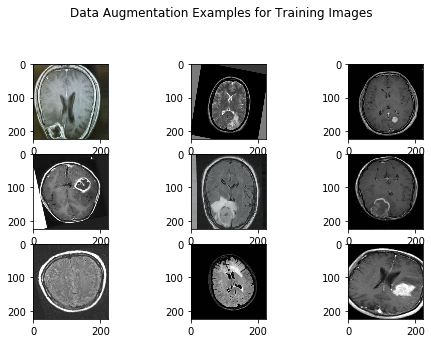

In [22]:
#Plot few training augmented images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(5,3,i+1)
    for X,Y in train_generator:
        image=X[0]
        plt.imshow(image)
        break
plt.suptitle('Data Augmentation Examples for Training Images')
#plt.tight_layout()
plt.show()

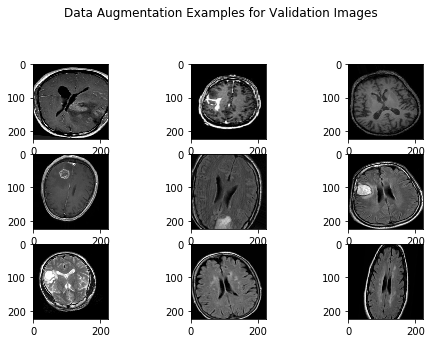

In [23]:
#Plot few validation augmented images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(5,3,i+1)
    for X,Y in val_generator:
        image=X[0]
        plt.imshow(image)
        break
plt.suptitle('Data Augmentation Examples for Validation Images')
#plt.tight_layout()
plt.show()

### 5. CNN from Scratch

Now our data is model-ready meaning it is pre-processed in a way such that it can be fed to the model. We will build a neural network using Keras library with various convolutional and pooling layers followed by fully-connected layers.

- While building a deep learning model from scratch, we can define any shape (h,w) to which the input images need to be re-sized. We have re-sized the image shape to (224,224) since later while using *transfer learning* approach, the images have to be in this shape. This is because if we use a pre-trained model(in our case, VGG16) we have to resize and normalise the input to the same format the network was originally trained on.


- Convolutional layer involves kernels/filters (filter size can be selected arbitarily) which are responsible to extract features from the input image.


- Next, activaton function, in this case *ReLU*, was applied on the generated feature map. The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.


- Pooling layer reduces the complexity of the model by reducing the number of parameters without degrading the performance. It provides an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map. Two common pooling methods are average pooling and max pooling that summarize the average presence of a feature and the most activated presence of a feature respectively.


- Next, we will introduce Dropout layer. Large neural nets trained on relatively small datasets can overfit the training data. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.


- We will stack above network twice before we move on to the final part of the model. For the last layer of architecture and the fully connected layer, the data will be converted into a single input matrix. Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer. 


- We are using *sigmoid* activation function in the final layer since this task involves binary classification.  

In [24]:
INPUT_SHAPE = (224,224,3)
n_class = 2

#Build the model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
          
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
          
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_class, activation='sigmoid'))  
#If we use loss function: loss='binary_crossentropy'
#model.add(Dense(1, activation='sigmoid')) 

In [25]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

In [26]:
#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Note**

- We can also use `losss=binary_crossentropy` since this is a binary classification task. As, we have already set `n_class=2`, hence the *categorical_crossentropy*  
- Generally, we use `loss=categorical_crossentropy` for multi-class problems.

In [27]:
print("Total Images in the Training Set: ", train_generator.n)
print("Batch size for epoch|Training: ",train_generator.batch_size)
print("Steps per Epoch|Training: ", train_generator.n//train_generator.batch_size)

print("Total Images in the Validation Set: ", val_generator.n)
print("Batch size for epoch|Validation: ",val_generator.batch_size)
print("Steps per Epoch|Validation: ", val_generator.n//val_generator.batch_size)

Total Images in the Training Set:  176
Batch size for epoch|Training:  32
Steps per Epoch|Training:  5
Total Images in the Validation Set:  37
Batch size for epoch|Validation:  32
Steps per Epoch|Validation:  1


We will set a criterion before we start training the model such that the model is saved everytime there is an increase in the `val_accuracy` from the previous epoch. This can be achieved by **ModelCheckpoint** callback class in Keras. 

The ModelCheckpoint callback class allows you to define where to checkpoint the model weights, how the file should named and under what circumstances to make a checkpoint of the model. The API allows you to specify which metric to monitor, such as loss or accuracy on the training or validation dataset.

In [28]:
#Save the model only if the 'val_accuracy' improves 
checkpoint_filepath = 'model_checkpoints/best_cnn_model.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_accuracy',
                                verbose=1,
                                mode='max',
                                save_best_only=True
                                )

Now, we will fit the image dataset to the above model and train for 30 epochs. An *epoch* can be thought of an iteration in which we feed the training images again and again for the neural network to get trained better with the training images and learn from it.

**Hyperparamters**

- `batch_size` determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. By default, it is set to **32**.
- `steps_per_epoch` the number of batch iterations before a training epoch is considered finished. If we have a training set of fixed size we can ignore it but it may be useful if we have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. 
- `validation_steps` similar to steps_per_epoch but on the validation data set instead on the training data. 

In [29]:
#Setting the hyperparameters
EPOCHS = 30

#Fit the model
#%%time
model_history = model.fit_generator(
                train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                epochs=EPOCHS,
                validation_data=val_generator,
                validation_steps=val_generator.n//val_generator.batch_size,
                callbacks=[model_checkpoint_callback])

W1006 03:28:37.021017 140330177029952 deprecation.py:323] From <ipython-input-29-1014128dad09>:12: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 1.1464 - accuracy: 0.5486
Epoch 00001: val_accuracy improved from -inf to 0.46875, saving model to model_checkpoints/best_cnn_model.ckpt


W1006 03:28:48.161222 140330177029952 deprecation.py:506] From /home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


5/5 [==============================] - 9s 2s/step - loss: 1.1464 - accuracy: 0.5486 - val_loss: 0.6958 - val_accuracy: 0.4688
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.4750
Epoch 00002: val_accuracy improved from 0.46875 to 0.56250, saving model to model_checkpoints/best_cnn_model.ckpt
5/5 [==============================] - 10s 2s/step - loss: 0.6989 - accuracy: 0.4750 - val_loss: 0.6899 - val_accuracy: 0.5625
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5188
Epoch 00003: val_accuracy did not improve from 0.56250
5/5 [==============================] - 8s 2s/step - loss: 0.6919 - accuracy: 0.5188 - val_loss: 0.6866 - val_accuracy: 0.5625
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5833
Epoch 00004: val_accuracy improved from 0.56250 to 0.62500, saving model to model_checkpoints/best_cnn_model.ckpt
5/5 [==============================] - 9s 2s/step - loss: 0.68

We can clearly see that the model has a highest validation accuracy of **84.375%** 


**Note**

- We can for sure try training for a greater number of epochs. Having said that, with the dataset being small, and the validation accuracy we have achieved above, it's difficult to get a significant improvement in terms of accuracy by just increasing the epochs count.


To analyze the model, we will now plot the loss and accuracy curves for both training and validation set spanning through each epoch.

In [30]:
#Plot the accuracy and loss curves 

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = np.arange(len(history.history['loss']))
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc='upper_right')
    plt.title('Training and Validation Loss')
    plt.show()
    

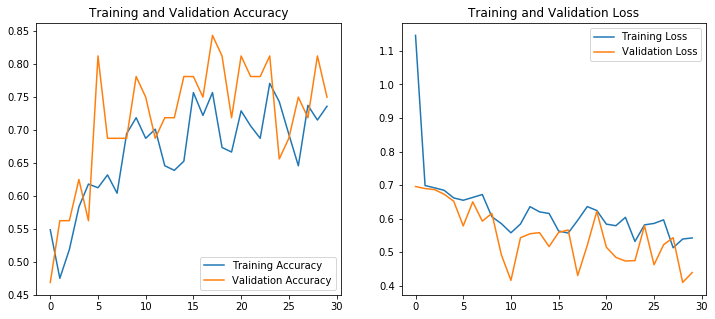

In [31]:
plot_metrics(model_history)

**Observation**

- In terms of accuracy, model achieves a significantly higher number despite of the fact that the dataset at disposal is small. Highest validation accuracy was achieved at 18th epoch post which there is a significant dip followed by steady increase as we move on to further epochs.
- In terms of loss, the behavior is as expected meaning a downward curve, however, the loss seems to increase post 20 epochs for both training and validation set but then gradually decreases.

Now, let's load the model with highest accuracy for validation dataset and evaluate the performance on the test dataset.

In [51]:
#Load the best model
best_model = load_model('model_checkpoints/best_cnn_model.ckpt/')
model.save('saved_models/cnn_model.h5')

#Evaluate performance on test dataset
test_loss, test_acc = best_model.evaluate_generator(test_generator, steps=1)
print('Test Accuracy = %.2f' % test_acc)

Test Accuracy = 0.85


We achieved a test accuracy of **85%** with a simple CNN model meaning the model can correctly classify about 85% of the test set images as Tumor or No Tumor. Now, let's plot the confusion matrix for the test dataset.

In [52]:
#Confusion Matrix for Test Data
Y_pred = best_model.predict_generator(test_generator, test_generator.n // test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm_cnn = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix\n', cm_cnn)


W1006 04:06:24.686871 140330177029952 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix
 [[ 5 11]
 [ 9 15]]


In [53]:
import plotly.express as px
data=cm_cnn
fig = px.imshow(data,
                labels=dict(x="Predicted Label", y="Actual Label",color="Count"),
                x=['No', 'Yes'],
                y=['No', 'Yes'],
                color_continuous_scale=px.colors.sequential.Inferno
               )
fig.update_layout(title='Confusion Matrix for Test Dataset|CNN', xaxis_nticks=36)
fig.update_xaxes(side="top")
fig.show()

### 6. Transfer Learning

Deep learning model built from scratch requires vast amount of data so as to learn the underlying features and be better at predictions. 
Since, there is not enough data in our case, we will switch on to an alternative approach.

**Transfer learning** is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. 

Many of the state-of-the art deep learning architectures have been openly shared by their respective teams.

**Computer Vision**

- VGG16
- VGG19
- Inception V3
- ResNet
- XCeption

**Transfer Learning Principle**

- Large Dataset, Different from Pre-trained Model's dataset: Train the entire model
- Large Dataset, Similar to the Pre-trained Model's dataset: Train some layers and leave others frozen
- Small Dataset, Different from Pre-trained Model's dataset: Train some layers and leave others frozen
- Small Dataset, Similar to the Pre-trained Model's dataset: Freeze the convolutional base


For this task, we will use VGG16 pre-trained model. This model works pretty well with image classification tasks for obvious reasons and hence the preferred choice in such problems.

We will download the weights from the VGG16 model. There is no requirement to import the last layer because we will include our own layers.

In other words, we will download the weights of VGG16 model trained on IMAGENET dataset and use it as feature extraction model. Here, the output of the model from a layer prior to the *output layer* of the model(in this case VGG16) is used as input to a new classifier model.

Hence, we will set `include_top=False` 

In [37]:
#Download the weights for VGG model
vgg_model = VGG16(input_shape = INPUT_SHAPE, weights='imagenet', include_top=False)

In [38]:
#Architecture of VGG16 model
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We will introduce *Batch Normalization* layer. Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [39]:
#Layer of the VGG16 model prior to the 'output layer'
final_layer = vgg_model.get_layer('block5_pool').output

#Add new classifier layers
x = Flatten(name='flatten')(final_layer)
x = Dropout(0.5, name='d1')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
x = BatchNormalization(name='bn1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dropout(0.5, name='d2')(x)
out = Dense(n_class, activation='softmax', name='output')(x)

#Define custom vgg model
custom_vgg_model = Model(inputs=vgg_model.inputs, outputs=out)


In [40]:
#Model architecture
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Since we don't want to train VGG16 layers, we can set `layer.trainable=False`

In [41]:
#Freeze all the layers except the dense layers
for layer in custom_vgg_model.layers[:-3]:
    layer.trainable = False

In [42]:
#Compile Model
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
#Save the model only if the 'val_acc' improves 
vgg_checkpoint_filepath = 'model_checkpoints/custom_vgg_model.ckpt'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=vgg_checkpoint_filepath,
                                monitor='val_accuracy',
                                verbose=1,
                                mode='max',
                                save_best_only=True
                                )

In [44]:
#Fit the model
vgg_model_history = custom_vgg_model.fit_generator(
                train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                epochs=EPOCHS,
                validation_data=val_generator,
                validation_steps=val_generator.n//val_generator.batch_size,
                callbacks=[vgg_checkpoint_callback])

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 1.7648 - accuracy: 0.5417
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to model_checkpoints/custom_vgg_model.ckpt
5/5 [==============================] - 16s 3s/step - loss: 1.7648 - accuracy: 0.5417 - val_loss: 0.6102 - val_accuracy: 0.6250
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.4861
Epoch 00002: val_accuracy did not improve from 0.62500
5/5 [==============================] - 17s 3s/step - loss: 0.9170 - accuracy: 0.4861 - val_loss: 0.6618 - val_accuracy: 0.6250
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.9119 - accuracy: 0.6250
Epoch 00003: val_accuracy did not improve from 0.62500
5/5 [==============================] - 20s 4s/step - loss: 0.9119 - accuracy: 0.6250 - val_loss: 0.8916 - val_accuracy: 0.3125
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.5278
Epoch 00004: val_accuracy di

Using transfer learning, we achieved validation accuracy of **87.5%** which is higher than the previous model.

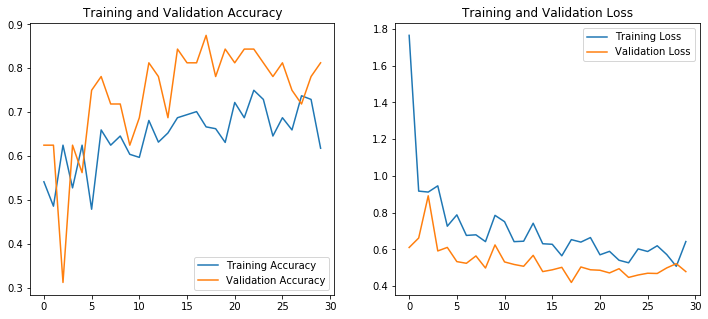

In [45]:
#Plot the accuracy and loss curves 
plot_metrics(vgg_model_history)

**Observations**

- Validation accuracy reaches its peak post 15th epoch following which there is a slight drop. 
- Loss curves tend to behave as expected meaning decreases with increase in epoch.
- Validation set tends to perform better(higher accuracy, lower loss) compared to train set which can be seen in both the model curves(simple cnn and vgg16). The reason being the use of `Dropout` layer as while training, a percentage of the features are set to zero. When testing or validating, all features are used. So the model at validation/test time is more robust and can lead to higher testing accuracies.

In [46]:
#Load the best model
best_vgg_model = load_model('model_checkpoints/custom_vgg_model.ckpt/')
model.save('saved_models/custom_vgg_model.h5')

#Evaluate performance on test dataset
test_loss, test_acc = best_vgg_model.evaluate_generator(test_generator, steps=1)
print('Test Accuracy = %.2f' % test_acc)

Test Accuracy = 0.82


In [49]:
#Confusion Matrix for Test Data
Y_pred = best_vgg_model.predict_generator(test_generator, test_generator.n // test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm_vgg = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix\n', cm_vgg)

W1006 04:02:36.901269 140330177029952 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix
 [[ 7  9]
 [ 6 18]]


In [50]:
import plotly.express as px
data=cm_vgg
fig = px.imshow(data,
                labels=dict(x="Predicted Label", y="Actual Label",color="Count"),
                x=['No', 'Yes'],
                y=['No', 'Yes'],
                color_continuous_scale=px.colors.sequential.Viridis
               )
fig.update_layout(title='Confusion Matrix for Test Dataset|VGG16', xaxis_nticks=36)
fig.update_xaxes(side="top")
fig.show()

**Observation**

- In classification problems, accuracy metric can be a bit misleading which is why Confusion matrix is preferred to analyze the performance of the model. 
- As we can see 25/40 images are classified correctly when trained using transfer learning approach compared to 20/40 images when the data was feeded to a model built from scratch.

### 7. Conclusion

- It is only fair to conclude that leveraging transfer learning especially when there is a small dataset at disposal can enhance the model performance significantly compared to a model built from scratch.   


- However, the performance can further be improved by increasing the dataset or via effective hyperparameters tuning. It is important to consider the fact that only hyperparameter tuning may not result in significant jump in accuracy or other classfication metrics


- Other pre-trained models such as ResNet50 were used but the model didn't perform well on this dataset and hence wasn't included in the notebook. In my understanding, the choice of pre-trained models is proportional to the complexity and the size of the dataset. VGG16 pre-trained model works well if the dataset at disposal is small and fairly simpler. If the dataset is complex, architectures like Inception V3, EfficientNet or ResNet101 can be used.


- Top rated Kaggle notebooks for this task did include an additional step of *cropping the images* so as to remove the unneccessary black areas/contours in the image apart from the MRI scan. While this will no doubt lead to a better performance but can't be generalised to every computer vision tasks since it isn't necessary to have such images in the dataset. 

### 8. Future Work

Deep learning models are considered as black boxes that do not explain their predictions in a way that humans can understand. *Xplainable AI* is the field which deals with techniques that help us understand model interpretability meaning the reasoning behind a particular image being classified as car and not bus.

This can be used for other computer vision projects as well.

### 9. References

- [Kaggle Notebooks](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection/notebooks)
- [Jason ML Mastery](https://machinelearningmastery.com/)